# Introdução e Objetivo

Este projeto visa prever preços de Bitcoin (BTC) utilizando redes neurais recorrentes (RNNs). Enfoque em séries temporais para capturar tendências de mercado.

In [47]:
# Importação de Bibliotecas e Configuração do Ambiente
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
# Coleta e Preparação dos Dados

# Importação e Pré-Processamento dos Dados
df = pd.read_csv('btc-usd-max.csv')

# Visualize as primeiras linhas e as colunas
print("Colunas do arquivo:")
print(df.columns)

print("\nPrimeiras 5 linhas:")
print(df.head())


Colunas do arquivo:
Index(['snapped_at', 'price', 'market_cap', 'total_volume'], dtype='object')

Primeiras 5 linhas:
                snapped_at   price    market_cap  total_volume
0  2013-04-28 00:00:00 UTC  135.30  1.500518e+09           0.0
1  2013-04-29 00:00:00 UTC  141.96  1.575032e+09           0.0
2  2013-04-30 00:00:00 UTC  135.30  1.501657e+09           0.0
3  2013-05-01 00:00:00 UTC  117.00  1.298952e+09           0.0
4  2013-05-02 00:00:00 UTC  103.43  1.148668e+09           0.0


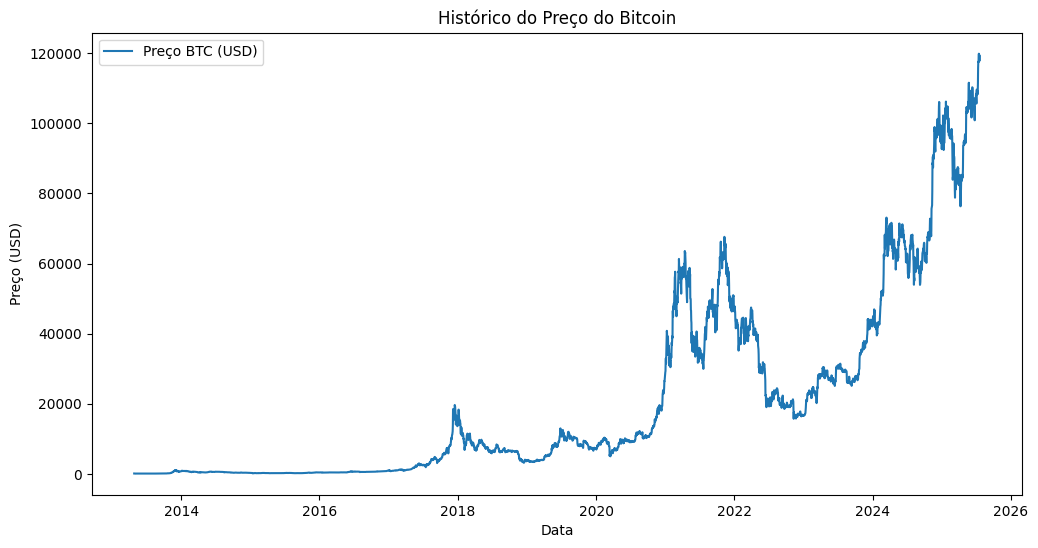

In [49]:

# Converter a Coluna de Data para o Formato Datetime
df['snapped_at'] = pd.to_datetime(df['snapped_at'])

# Configurar a Coluna snapped_at como Índice
df.set_index('snapped_at', inplace=True)

# Ordenar os Dados pelo Índice de Data
df = df.sort_index()

# Selecionar apenas a Coluna de Preço
df = df[['price']].dropna()

# Visualização do Histórico de Preços
plt.figure(figsize=(12, 6))
plt.plot(df, label="Preço BTC (USD)")
plt.title("Histórico do Preço do Bitcoin")
plt.xlabel("Data")
plt.ylabel("Preço (USD)")
plt.legend()
plt.show()



In [50]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# ======= HIPERPARÂMETROS =======
# Definição dos hiperparâmetros ajustáveis
HYPERPARAMS = {
    "sequence_length": 60,  # Comprimento da janela temporal
    "train_test_split": 0.8,  # Proporção entre treino e teste
    "batch_size": 32,  # Tamanho dos lotes para o treinamento
    "shuffle_seed": 42  # Semente usada no embaralhamento dos dados
}

# ======= FUNÇÃO PARA CRIAR SEQUÊNCIAS =======
def create_sequences(data, sequence_length):
    """
    Cria janelas temporais de tamanho `sequence_length` para treinamento em séries.
    :param data: Dados normalizados como array numpy.
    :param sequence_length: Comprimento da sequência (ex: 60 dias).
    :return: Sequências (X) e Labels (y) como arrays numpy.
    """
    sequences = []
    labels = []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i])  # Coleta uma janela de sequência
        labels.append(data[i])  # Próximo valor após a janela é o label
    return np.array(sequences), np.array(labels)

# ======= NORMALIZAÇÃO E PREPARAÇÃO DOS DADOS =======
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values)  # Normaliza a coluna 'price' para [0, 1]

# Definição da janela temporal utilizando o hiperparâmetro
sequence_length = HYPERPARAMS["sequence_length"]

# Criação das sequências temporais
X, y = create_sequences(data_scaled, sequence_length)

# Separação do dataset em treino e teste usando o hiperparâmetro de split
split = int(len(X) * HYPERPARAMS["train_test_split"])  # Ex.: 80% treino, 20% teste
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Embaralhar o conjunto de treino (evita dependência de padrões sequenciais)
X_train, y_train = shuffle(X_train, y_train, random_state=HYPERPARAMS["shuffle_seed"])

# ======= INFORMAÇÕES DOS DADOS =======
print(f"Comprimento da sequência temporal: {sequence_length}")
print(f"Tamanho total do dataset: {len(X)}")
print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"Tamanho do batch: {HYPERPARAMS['batch_size']}")

Comprimento da sequência temporal: 60
Tamanho total do dataset: 4404
Tamanho do conjunto de treino: 3523
Tamanho do conjunto de teste: 881
Tamanho do batch: 32


In [51]:
from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(
        64,  # Número de neurônios ajustados
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        kernel_regularizer=regularizers.l2(0.01)  # Adição de Regularização L2
    ),
    tf.keras.layers.Dropout(0.4),  # Aumento do Dropout para reduzir overfitting
    tf.keras.layers.LSTM(
        64,
        return_sequences=False,
        kernel_regularizer=regularizers.l2(0.01)
    ),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(
        32,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Taxa de aprendizado ajustada
    loss='mean_squared_error'
)
model.summary()


C:\Users\jamyl\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2260
Epoch 1: val_loss improved from inf to 0.61570, saving model to best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.2210 - val_loss: 0.6157 - learning_rate: 5.0000e-04
Epoch 2/50
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5054
Epoch 2: val_loss improved from 0.61570 to 0.25383, saving model to best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.5033 - val_loss: 0.2538 - learning_rate: 5.0000e-04
Epoch 3/50
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2091
Epoch 3: val_loss improved from 0.25383 to 0.11056, saving model to best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2078 - val_loss: 0.1106 - learning_rate: 5.0000e-04
Epoch 4/50
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0919
Epoch 4: val_loss improved from 0.11056 to 0.04793, saving model to best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0913 - val_loss: 0.0479 - learning_rate: 5.0

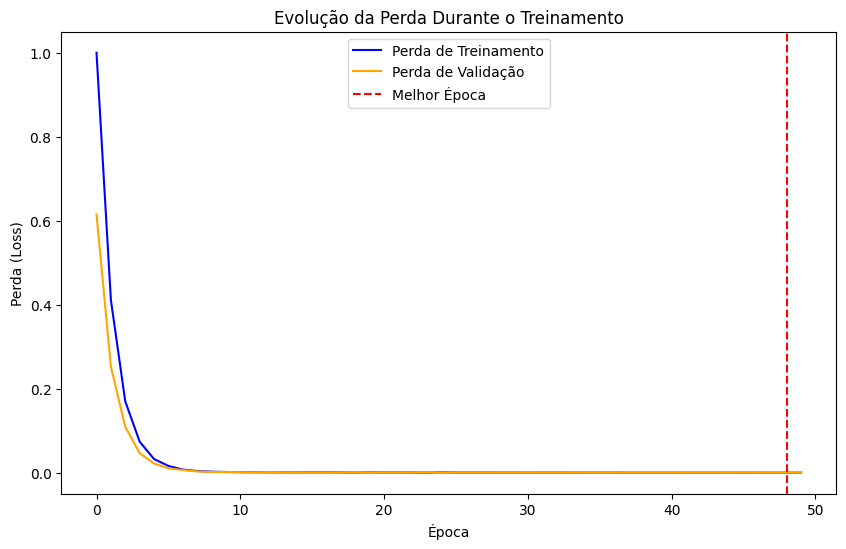

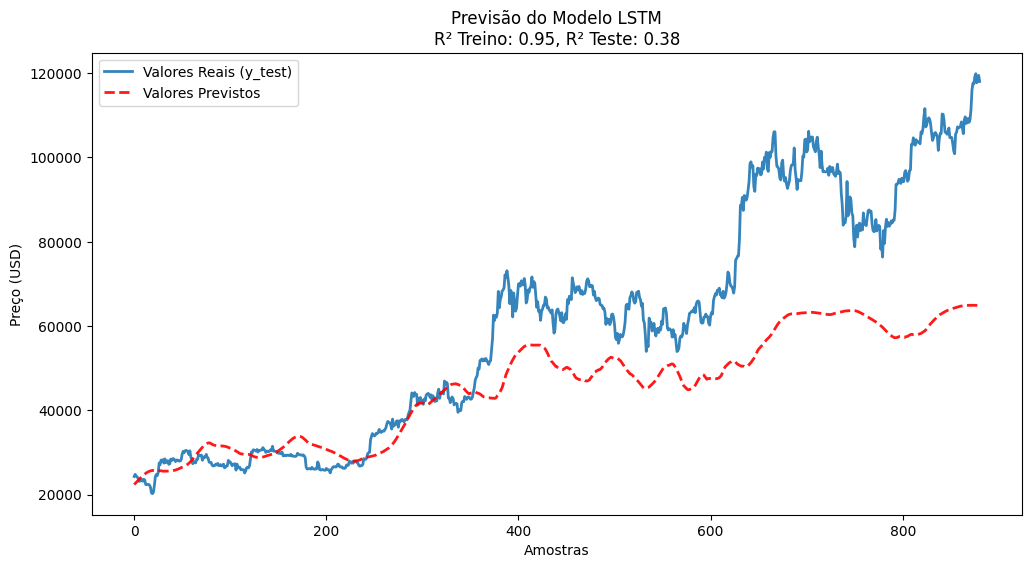

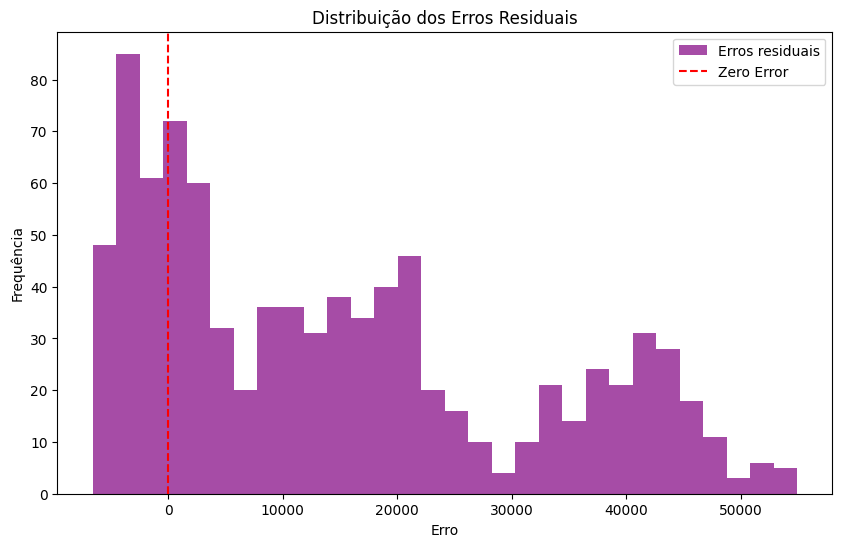

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ======= CALLBACKS =========
# Early Stopping: Interrompe o treinamento quando a perda de validação para de melhorar
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Nº de épocas sem melhoria para interromper
    restore_best_weights=True  # Retorna ao melhor conjunto de pesos
)

# Checkpoints: Salva o melhor modelo durante o treinamento
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Caminho do arquivo
    monitor='val_loss',
    save_best_only=True,  # Salva apenas os melhores pesos
    verbose=1
)

# Scheduler: Decaimento da taxa de aprendizado
def scheduler(epoch, lr):
    return lr * 0.9 if epoch > 10 else lr  # Reduz gradualmente após 10 épocas

lr_scheduler = LearningRateScheduler(scheduler)

# ======= TREINAMENTO =========
history = model.fit(
    X_train,
    y_train,
    batch_size=32,  # Reduziu o batch para captar melhor a variabilidade
    epochs=50,  # Número maior de épocas com callbacks para controle
    validation_split=0.2,  # Separação de validação
    callbacks=[early_stopping, checkpoint, lr_scheduler],  # Adicionei os callbacks
    verbose=1
)

# Avaliação Final no Conjunto de Teste
loss = model.evaluate(X_test, y_test)
print(f"Loss no conjunto de teste: {loss}")

# ======= MÉTRICAS =========
# Previsões no conjunto de treino e teste (revertendo normalização)
train_predictions = scaler.inverse_transform(model.predict(X_train))
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
predictions = scaler.inverse_transform(model.predict(X_test))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo de métricas adicionais
r2_train = r2_score(y_train_actual, train_predictions)
r2_test = r2_score(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))

print(f"R² no conjunto de treinamento: {r2_train:.2f}")
print(f"R² no conjunto de teste: {r2_test:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# ======= VISUALIZAÇÕES =========
# Histórico de treinamento (perda de treino e validação)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Perda de Treinamento', color='blue')
plt.plot(val_loss, label='Perda de Validação', color='orange')
plt.axvline(np.argmin(val_loss), color='red', linestyle='--', label='Melhor Época')  # Destaque para o melhor ponto
plt.title('Evolução da Perda Durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.show()

# Visualização de previsões no conjunto de teste
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Valores Reais (y_test)", linewidth=2, alpha=0.9)
plt.plot(predictions, label="Valores Previstos", linestyle='--', linewidth=2, alpha=0.9, color='red')
plt.title(f"Previsão do Modelo LSTM\nR² Treino: {r2_train:.2f}, R² Teste: {r2_test:.2f}")
plt.xlabel("Amostras")
plt.ylabel("Preço (USD)")
plt.legend()
plt.show()

# Visualização erros residuais
errors = y_test_actual - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='purple', alpha=0.7, label='Erros residuais')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribuição dos Erros Residuais')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.legend()
plt.show()


## Conclusões e Próximos Passos

- **Resultados**: O modelo apresentou uma capacidade razoável de previsões em curto prazo.
- **Limitações**: Execução pode ser aprimorada ajustando hiperparâmetros e explorando maior volume de dados.
- **Futuro**: Incorporar mais características (indicadores financeiros) e testar outras arquiteturas de rede.